In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from scipy import optimize as opt
from scipy.optimize import broyden1, minimize
from scipy import stats as sts
from matplotlib import pyplot as plt
from functools import partial
from statsmodels.formula import api as sm

## Lucas Tree Model

In [4]:
start = datetime.datetime(1970, 10, 1)
end = datetime.datetime(2018, 7, 1)

rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
gdpdef = web.DataReader('GDPDEF', 'fred', start, end)
tbill = web.DataReader('TB3MS', 'fred', start, end)

tbill = tbill.fillna(method="ffill")
w5000 = w5000.fillna(method="ffill")
tbill = tbill.resample('QS').first()
w5000 = w5000.resample('QS').first()

df = pd.DataFrame(columns=['rpce', 'w5000', 'tbill', 'gdpdef'], index = rpce.index)



df['rpce'] = rpce
df['w5000'] = w5000
df['tbill'] = tbill / 100 + 1
df['gdpdef'] = (gdpdef / 100)
df['gdpdef'] /= df['gdpdef'][0]
df['real_w5000'] = df['w5000'] / (df['gdpdef'])
df['R'] = df['real_w5000'] / df['real_w5000'].shift(1)

df.dropna(axis=0, inplace=True)
df.head()

,rpce,w5000,tbill,gdpdef,real_w5000,R
DATE,,,,,,
1971-01-01,3156.978,1.00,1.0444,1.015189,0.985039,0.985039
1971-04-01,3185.993,1.12,1.0386,1.028518,1.088945,1.105485
1971-07-01,3211.394,1.13,1.0540,1.038992,1.087593,0.998758
1971-10-01,3264.679,1.12,1.0446,1.047651,1.069058,0.982958
1972-01-01,3307.767,1.18,1.0338,1.063565,1.109476,1.037807


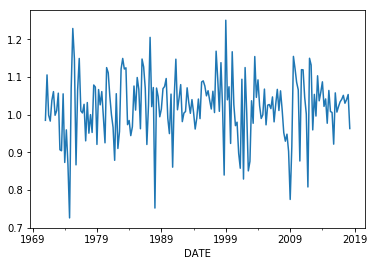

In [5]:
df['R'].plot()
plt.show()

### QUESTION 1:

In [6]:
beta = 0.99

In [7]:
# Write functions

def sdf(gamma, df, beta):
    mu = df['rpce'] ** (-gamma)
    return beta * (mu.shift(-1) / mu)

def objective(gamma, *args):
    df, beta = args
    Rt1 = df['R']
    mut1 = sdf(gamma, df, beta)
    return 1 - mut1.cov(Rt1) - mut1.mean() * Rt1.mean()


In [8]:
result_1 = opt.root(objective, 1.0, args=(df, beta))
gamma_opt = result_1.x[0]
print("Gamma = ", gamma_opt)


Gamma =  1.3643618411609897


### QUESTION 2:

Verify different equations produce equivalent result. Can also see if results change by using different/updated data, as a sort of sensitivity

### QUESTION 3:

In [10]:
def objective_2(γ, *args):
    df, β = args
    rf = df['tbill']
    E_mt1 = sdf(γ, df, β).mean()
    errors = rf - (1 / E_mt1)
    return np.sum(errors ** 2)

In [11]:
result_2 = opt.root(objective_2, 1.0, args=(df, beta))
gamma_opt2 = result_2.x[0]
print("Gamma = ", gamma_opt2)

Gamma =  4.87489828116734


### QUESTION 4:

In [12]:
def errors(β, γ, df):
    Rt1 = df['R']
    mt1 = sdf(γ, df, β)
    error_1 = 1 - mt1.cov(Rt1) - mt1.mean() * Rt1.mean()
    rf = df['tbill']
    E_mt1 = mt1.mean()
    error_2 = np.sum((rf - (1 / E_mt1)) ** 2)
    return np.array([error_1, error_2])

def objective_3(params, df):
    β, γ = params
    return np.sum(errors(β, γ, df) ** 2)



γ = 3.000621328189787
β = 0.976872579615234


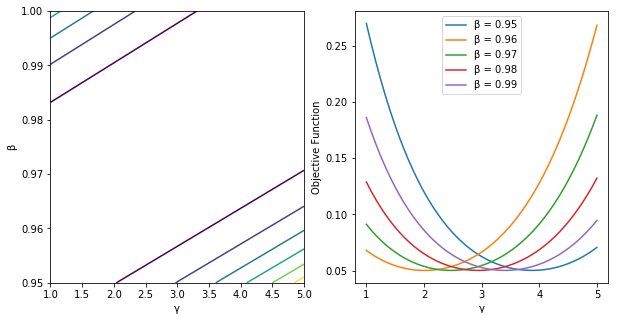

In [14]:
guess = np.array([1.0, 3.0])
result_4 = opt.minimize(objective_3, guess, args=df)
opt_β_4, opt_γ_4 = result_4.x
print(f'γ = {opt_γ_4}\nβ = {opt_β_4}')

β_grid = np.linspace(0.95, 1, 50)
γ_grid = np.linspace(1, 5, 50)

Β, Γ = np.meshgrid(β_grid, γ_grid)
obj = np.empty_like(Β)
for i, γ in enumerate(γ_grid):
    for j, β in enumerate(β_grid):
        obj[i, j] = objective_3([β, γ], df)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].contour(Γ, Β, obj)
axes[0].set_xlabel("γ")
axes[0].set_ylabel("β")
for i, β in enumerate(β_grid[::10]):
    axes[1].plot(γ_grid, obj[10 * (i - 1)], label=f"β = {round(β, 2)}")
axes[1].legend()
axes[1].set_xlabel("γ")
axes[1].set_ylabel("Objective Function")
plt.show()

## Kyle model

In [25]:
import pickle

### QUESTION 1:

In [17]:
# Load data - note, i've added the data folder to the working directory
AAPL = pickle.load(open("./data/AAPL", "rb"))
C = pickle.load(open("./data/C", "rb"))
GBX = pickle.load(open("./data/GBX", "rb"))
SPY = pickle.load(open("./data/SPY", "rb"))
THO = pickle.load(open("./data/THO", "rb"))



In [19]:
# Class design
class OrderBook:

    def __init__(self, data, window, name):
        
        self.data = data[1]
        self.timestamp = data[0]
        self.lower = window[0]
        self.upper = window[1]
        self.name = name
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        df.columns = ['Quantity', 'Type', 'NaN0','NaN1']
        df = df[['Quantity', 'Type']]
        
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        orders = pd.concat([self.demand, self.supply])
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        self.orders = orders[(orders.index > window[0] * self.midpoint) 
                             & (orders.index < window[1]* self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def est(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.price = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot(self):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='demand')
        plt.plot(self.supply.index.values, self.supply['QS'], label='supply')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'k', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(self.name + ' Stock at t = %i' %self.timestamp)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated market clearing price of", self.name, "is: %f" %self.price)
        print("The actual midpoint of the BBO of", self.name, "is: %f" %self.midpoint)
        
    def show(self):
        self.est()
        self.plot()

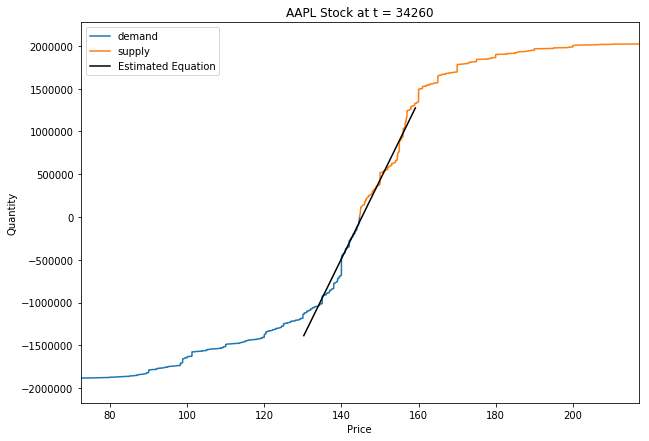

In [20]:
aapl0 = OrderBook(AAPL[0], (0.9, 1.1), "AAPL")
aapl0.show()

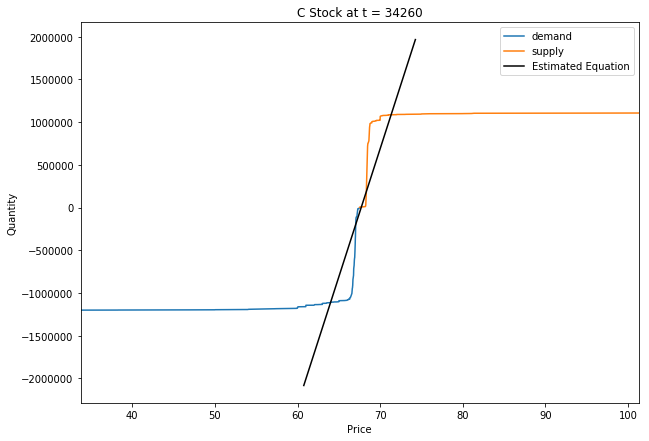

In [21]:
cl0 = OrderBook(C[0], (0.9, 1.1), "C")
cl0.show()

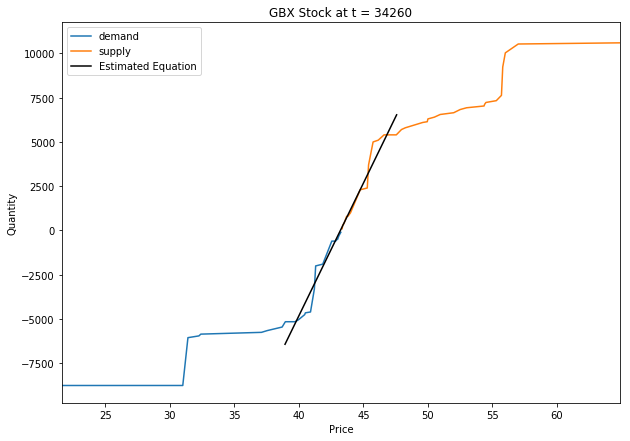

In [22]:
gbxl0 = OrderBook(GBX[0], (0.9, 1.1), "GBX")
gbxl0.show()

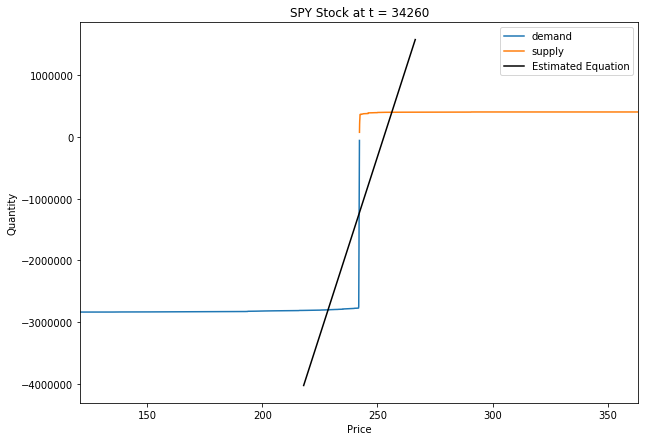

In [23]:
spyl0 = OrderBook(SPY[0], (0.9, 1.1), "SPY")
spyl0.show()


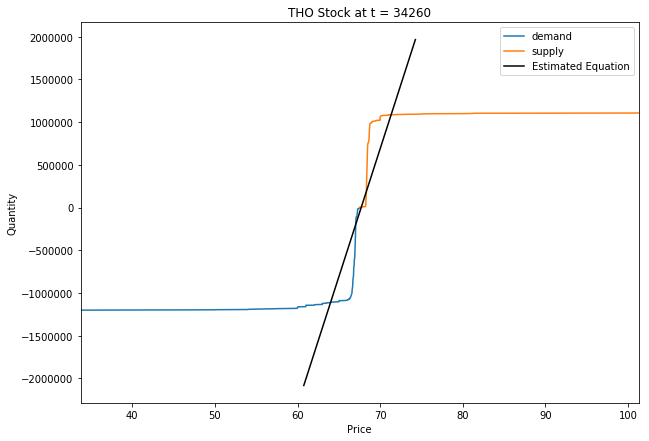

In [24]:
thol0 = OrderBook(C[0], (0.9, 1.1), "THO")
thol0.show()

As discussed in class, the linearization fits best towards the middle, where assets demanded is meeting assets supplied and transactions are occuring. Thus, perhaps we could discard the data in the tails, depending on the questions we want to answer.

### QUESTION 2:

In [26]:
def plot_ratios(file_obj, name):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for i in range(len(file_obj)):
        book = OrderBook(file_obj[i], (0.9, 1.1), name)
        book.est()
        ratio[i] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel('Estimated Ratio')
    plt.show()



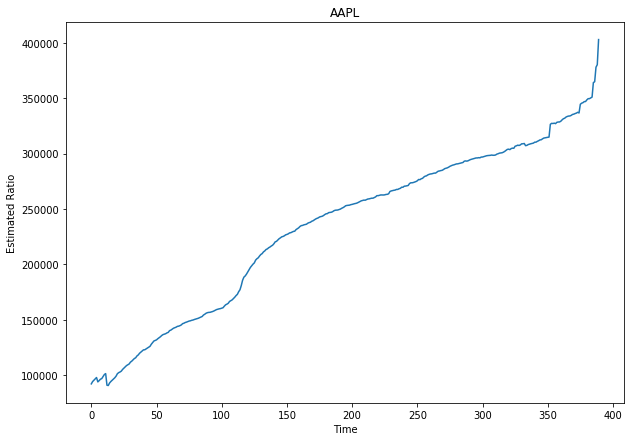

In [27]:
plot_ratios(AAPL, 'AAPL')

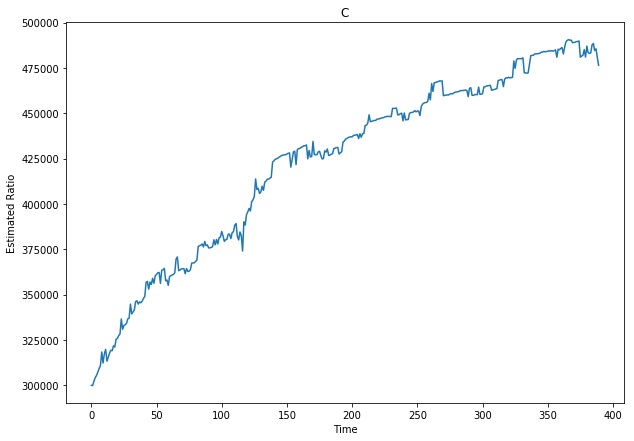

In [28]:
plot_ratios(C, 'C')

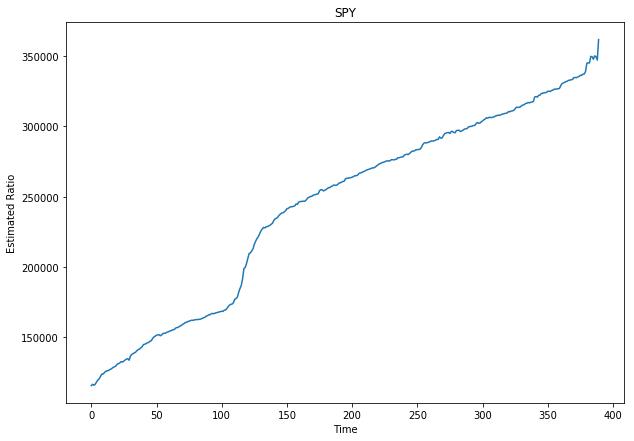

In [29]:
plot_ratios(SPY, 'SPY')

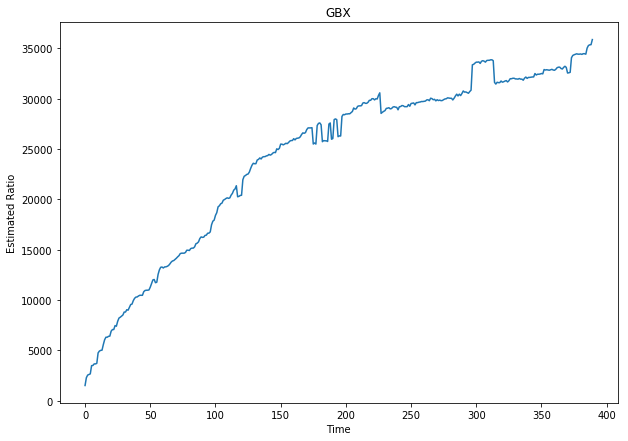

In [30]:
plot_ratios(GBX, 'GBX')

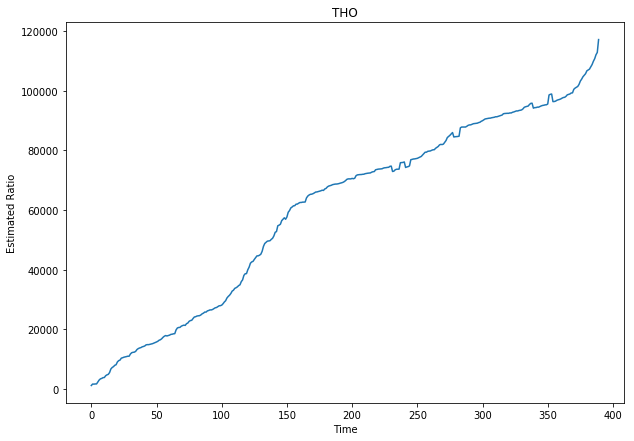

In [31]:
plot_ratios(THO, 'THO')

### QUESTION 3:

In [35]:
aapl0.compare()
print()
cl0.compare()
print()
gbxl0.compare()
print()
spyl0.compare()
print()
spyl0.compare()

The estimated market clearing price of AAPL is: 145.304897
The actual midpoint of the BBO of AAPL is: 144.700000

The estimated market clearing price of C is: 67.706617
The actual midpoint of the BBO of C is: 67.510000

The estimated market clearing price of GBX is: 43.213939
The actual midpoint of the BBO of GBX is: 43.250000

The estimated market clearing price of SPY is: 252.752189
The actual midpoint of the BBO of SPY is: 242.180000

The estimated market clearing price of SPY is: 252.752189
The actual midpoint of the BBO of SPY is: 242.180000
